In [1]:
import pandas as pd
import numpy as np
import os

## Creating the Dataloader

In [2]:
dfs = []
ys = []
for file in os.listdir('data/abundance/'):
    df = pd.read_csv('data/abundance/' + file, sep = '\t') 
#     y = pd.read_csv('data/marker/' + 'marker' + '_' + file.split('_')[1] , sep = '\t').head(5)
    
    df.index = df.dataset_name
    dfs.append(df.T.drop('dataset_name') )
    
#     y.index = y.dataset_name
#     ys.append(y.T.drop('dataset_name'))
    
    
dfs[3].loc[dfs[3].disease=='leaness', 'disease']='n'

In [3]:
!ls data/marker

marker_Cirrhosis.txt  marker_IBD.txt        marker_T2D.txt
marker_Colorectal.txt marker_Obesity.txt    marker_WT2D.txt


In [4]:
test = pd.read_csv('data/marker/marker_Colorectal.txt', sep = '\t')
test.index = test.dataset_name
test = test.T.drop('dataset_name')

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
test.columns[test.columns.str.contains('gi[|]')]

Index(['gi|104773257|ref|NC_008054.1|:116729-117526',
       'gi|104773257|ref|NC_008054.1|:1737697-1738332',
       'gi|104773257|ref|NC_008054.1|:266275-267207',
       'gi|104773257|ref|NC_008054.1|:294312-294563',
       'gi|104773257|ref|NC_008054.1|:444407-444904',
       'gi|104773257|ref|NC_008054.1|:54492-55274',
       'gi|104773257|ref|NC_008054.1|:794401-794844',
       'gi|104773257|ref|NC_008054.1|:c1060211-1059462',
       'gi|104773257|ref|NC_008054.1|:c1169983-1168085',
       'gi|104773257|ref|NC_008054.1|:c1327487-1326282',
       ...
       'gi|62425186|ref|NZ_AAGP01000009.1|:99890-100180',
       'gi|62425382|ref|NZ_AAGP01000007.1|:c1202-885',
       'gi|62425382|ref|NZ_AAGP01000007.1|:c33801-33373',
       'gi|62425382|ref|NZ_AAGP01000007.1|:c34305-33829',
       'gi|62425604|ref|NZ_AAGP01000005.1|:60113-60766',
       'gi|62425604|ref|NZ_AAGP01000005.1|:97318-98013',
       'gi|62425739|ref|NZ_AAGP01000004.1|:59838-60017',
       'gi|62425898|ref|NZ_AAGP01000003.

In [6]:
test.shape

(121, 108244)

In [7]:
[df.disease.value_counts() for df in dfs]

[cirrhosis    118
 n            114
 Name: disease, dtype: int64,
 t2d    53
 n      43
 Name: disease, dtype: int64,
 cancer           48
 n                47
 small_adenoma    26
 Name: disease, dtype: int64,
 obesity    164
 n           89
 Name: disease, dtype: int64,
 n                         85
 ibd_ulcerative_colitis    21
 ibd_crohn_disease          4
 Name: disease, dtype: int64,
 n      174
 t2d    170
 Name: disease, dtype: int64]

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [9]:
cols = []
[cols.append( df.columns[df.columns.str.contains('k__')] ) for df in dfs]

[None, None, None, None, None, None]

In [258]:
Dataset()

class MicroDataset(Dataset):
    """Dataset class for column dataset.
    Args:
       cats (list of str): List of the name of columns contain
                           categorical variables.
       conts (list of str): List of the name of columns which 
                           contain continuous variables.
       y (Tensor, optional): Target variables.
       is_reg (bool): If the task is regression, set ``True``, 
                      otherwise (classification) ``False``.
       is_multi (bool): If the task is multi-label classification, 
                        set ``True``.
    """
    def __init__(self, df, is_marker = False):
        df = df.sample(frac=1)
        if not is_marker:
            self.taxa_cols = df.columns[df.columns.str.contains('k__')] 
        else:
            self.taxa_cols = df.columns[df.columns.str.contains('gi[|]')] 
        self.matrix = torch.Tensor( df[self.taxa_cols].astype(float).values ).float()
        self.y = torch.Tensor(df.disease != 'n' ).long()
        
        self.n_samples, self.n_taxa= self.matrix.shape
        
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return [self.matrix[idx], self.y[idx]]

In [11]:
dataset = MicroDataset(dfs[0])
loader = DataLoader(dataset, batch_size = 50, shuffle = True)

In [12]:
def make_split(df, perc = .8):
    df = df.sample(frac = 1)
    neg_samps = df.loc[df.disease == 'n']
    pos_samps = df.loc[df.disease != 'n']
    
    neg_idx = round( neg_samps.shape[0] * perc )
    pos_idx = round( pos_samps.shape[0] * perc )
    
    train = pd.concat( [neg_samps.iloc[:neg_idx], 
                       pos_samps.iloc[:pos_idx] ], axis = 0 )
    
    valid = pd.concat( [neg_samps.iloc[neg_idx:], 
                       pos_samps.iloc[pos_idx:] ], axis = 0 )
    
    return(train, valid)

## creating the baseline models

In [13]:
dataset.n_taxa

542

In [14]:
class FFNN(torch.nn.Module):
    def __init__(self, 
                 dataset, 
                 layer_sizes = [128, 64, 32], 
                dropout = .2):
        super(FFNN, self).__init__()
        
        linear_layers = [ nn.Linear( dataset.n_taxa, layer_sizes[0]), 
                          nn.BatchNorm1d(layer_sizes[0]), 
                          nn.Dropout(dropout), 
                          nn.GELU()]
        
        for i in range(len(layer_sizes)-1):
            linear_layers += [ nn.Linear(layer_sizes[i], layer_sizes[i+1]), 
                               nn.BatchNorm1d(layer_sizes[i+1]), 
                               nn.Dropout(dropout), 
                               nn.GELU()]
            
        linear_layers += [ nn.Linear(layer_sizes[-1], 2), 
                           nn.Softmax() ]
        
        self.linear_net = nn.Sequential(*linear_layers)
        
    def forward(self, x):
        out = self.linear_net(x.float())
        return(out)
    
    
    
    
class SAE(torch.nn.Module):
    """
    The shallow autoencoder
    """
    def __init__(self, 
                 dataset, 
                 layer_dim = 64, 
                 dropout = .2):
        super(SAE, self).__init__()
        self.encoder = nn.Sequential(*[nn.Linear(dataset.n_taxa, layer_dim), nn.ReLU()])
        self.decoder = nn.Sequential(*[nn.Linear(layer_dim, dataset.n_taxa), nn.ReLU(), nn.Softmax()])
        
    def forward(self, x):
        out = self.decoder( self.encoder(x) )
        return(out)
    
    def encode(self, x):
        return( self.encoder(x) )

In [18]:
model = FFNN(dataset)

In [19]:
import pytorch_lightning as pl
import torch.nn.functional as F

In [20]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.Tensor( np.eye(num_classes, dtype='uint8')[y] )

In [21]:
class LitClassifier(pl.LightningModule):
    def __init__(self, 
                 train_df,
                 valid_df, 
                 layer_sizes = [128, 64, 32],
                 dropout = .2,
                 learning_rate=1e-3):
        super().__init__()
        
        self.train_dataset = MicroDataset(train_df)
        self.valid_dataset = MicroDataset(valid_df)
        #self.test_dataset = MicroDataset(test_df)
        
        
        self.train_loader = DataLoader(self.train_dataset, batch_size = 50, shuffle = True)
        self.valid_loader = DataLoader(self.valid_dataset, batch_size = 50, shuffle = False)
        #test_dataloader = DataLoader(self.test_dataset, batch_size = 50, shuffle = False)
        self.model = FFNN(self.train_dataset, layer_sizes = layer_sizes, dropout = dropout)
        self.learning_rate = learning_rate
        
        
    def train_dataloader(self):
        return(self.train_loader)
    
    def valid_dataloader(self):
        return(self.valid_loader)
    
    def forward(self, x):
        x = self.model(x)
        return x

    def split_batch(self, batch):
        return batch[0], batch[1]

    def training_step(self, batch, batch_idx):
        x, y = self.split_batch(batch)
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = self.split_batch(batch)
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)

#     def test_step(self, batch, batch_idx):
#         x, y = self.split_batch(batch)
#         y_hat = self(x)
#         loss = F.cross_entropy(y_hat, y)
#         self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

#     @staticmethod
#     def add_model_specific_args(parent_parser):
#         parser = parent_parser.add_argument_group("LitClassifier")
#         parser.add_argument('--hidden_dim', type=int, default=128)
#         parser.add_argument('--learning_rate', type=float, default=0.0001)
#         return parent_parser


In [139]:
class LitEncoderDecoder(pl.LightningModule):
    def __init__(self, 
                 train_df,
                 valid_df, 
                 layer_dim = 64,
                 dropout = .2,
                 learning_rate=1e-3):
        super().__init__()
        
        self.train_dataset = MicroDataset(train_df)
        self.valid_dataset = MicroDataset(valid_df)
        #self.test_dataset = MicroDataset(test_df)
        
        
        self.train_loader = DataLoader(self.train_dataset, batch_size = 50, shuffle = True)
        self.valid_loader = DataLoader(self.valid_dataset, batch_size = 50, shuffle = False)
        #test_dataloader = DataLoader(self.test_dataset, batch_size = 50, shuffle = False)
        self.model = SAE(self.train_dataset, layer_dim = layer_dim, dropout = dropout)
        self.learning_rate = learning_rate
        
        # they use MSE for reconstruction loss
        self.loss_func = nn.MSELoss()
        self.log('val_loss', 10)
        
        
    def train_dataloader(self):
        return(self.train_loader)
    
    def valid_dataloader(self):
        return(self.valid_loader)
    
    def forward(self, x):
        x = self.model(x)
        return x

    def split_batch(self, batch):
        return batch[0], batch[1]

    def training_step(self, batch, batch_idx):
        x, y = self.split_batch(batch)
        y_hat = self(x)
        loss = self.loss_func(y_hat, x)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = self.split_batch(batch)
        y_hat = self(x)
        loss = self.loss_func(y_hat, x)
        self.log('val_loss', loss)

#     def test_step(self, batch, batch_idx):
#         x, y = self.split_batch(batch)
#         y_hat = self(x)
#         loss = F.cross_entropy(y_hat, y)
#         self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)



## running initial test

In [23]:
train_df, valid_df = make_split(dfs[0])

In [24]:
# lightning = LitClassifier(train_df, 
#                           valid_df, 
#                           layer_sizes = [200], learning_rate = 1e-5)

# they report that cirhossis SAE did best with layer dim of 32, learning rate .001
lightning = LitEncoderDecoder(train_df, 
                          valid_df, 
                          layer_dim = 32, learning_rate = .001)

In [25]:
trainer = pl.Trainer(max_epochs = 200,
                     check_val_every_n_epoch=10 )

trainer.fit(lightning)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | model     | SAE     | 35.3 K
1 | loss_func | MSELoss | 0     
--------------------------------------
35.3 K    Trainable params
0         Non-trainable params
35.3 K    Total params
0.141     Total estimated model params size (MB)


Epoch 7:  25%|██▌       | 1/4 [00:00<00:00, 163.29it/s, loss=2.63, v_num=20]

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 199: 100%|██████████| 4/4 [00:00<00:00, 130.54it/s, loss=2.53, v_num=20]


1

In [26]:
for batch in lightning.train_loader:
    break

In [27]:
batch[0].shape

torch.Size([50, 542])

In [29]:
import matplotlib.pyplot as plt

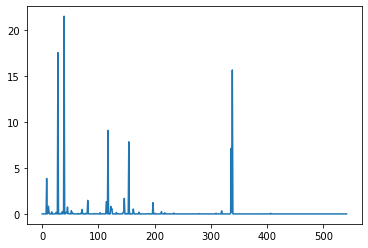

In [30]:
plt.plot( batch[0][0] )

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


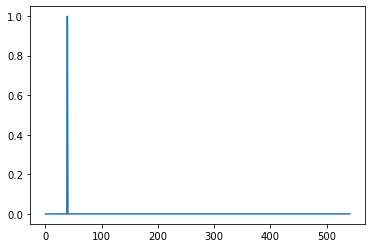

In [31]:
plt.plot( lightning(batch[0]).detach().numpy()[0] )

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [33]:
def run_training(train_df,
                y,
                n_folds = 5, 
                model = RandomForestClassifier(), 
                shuffle = True):

        #split the positive/negative samples so we can have evenly distributed folds
        t1, t2 = train_df[y==0], train_df[y==1]

        if shuffle:
            np.random.shuffle(t1), np.random.shuffle(t2)

        t1_folds = np.linspace(0, t1.shape[0], n_folds+1, dtype = np.int64)
        t1_folds = [ (t1_folds[i], t1_folds[i+1]) for i in range(n_folds) ]

        t2_folds = np.linspace(0, t2.shape[0], n_folds+1, dtype = np.int64)
        t2_folds = [ (t2_folds[i], t2_folds[i+1]) for i in range(n_folds) ]


        all_trues = list()
        all_preds = list()

        t1_split = [t1[a[0]:a[1]] for a in t1_folds]
        t2_split = [t2[a[0]:a[1]] for a in t2_folds]

        for i in range(n_folds):

            t1_train = np.vstack( [x for j,x in enumerate(t1_split) if j!=i] )
            t2_train = np.vstack( [x for j,x in enumerate(t2_split) if j!=i] )

            t1_test = t1_split[i]
            t2_test = t2_split[i]

            train_labels = np.hstack((np.zeros(t1_train.shape[0]),
                       np.ones(t2_train.shape[0]) ) )

            test_labels = np.hstack((np.zeros(t1_test.shape[0]),
                       np.ones(t2_test.shape[0]) ) )

            full_train = np.vstack((t1_train, t2_train))
            full_test = np.vstack((t1_test, t2_test))

            rf = model#RandomForestClassifier()
            rf.fit(full_train, train_labels)

            all_trues.append( test_labels )
            all_preds.append( rf.predict_proba(full_test) )

        y = np.hstack(all_trues)
        y_hat = np.vstack(all_preds)[:, 1]

        return(roc_curve(y, y_hat), rf)

In [34]:
DDD = MicroDataset(train_df)

In [35]:
#roc, model = run_training(lightning.model.encode(DDD.matrix).detach().numpy(), DDD.y.detach().numpy() )
roc, model = run_training(DDD.matrix.detach().numpy(), DDD.y.detach().numpy() )

In [36]:
auc(roc[0], roc[1])



0.9448795884966098

In [41]:
# test_preds = model.predict_proba( lightning.model.encode(lightning.valid_dataset.matrix).detach().numpy() )
# da_roc = roc_curve(lightning.valid_dataset.y.detach().numpy(), test_preds[:, 1])
# auc(da_roc[0],da_roc[1])

In [42]:
test_preds = model.predict_proba( lightning.valid_dataset.matrix.detach().numpy() )
da_roc = roc_curve(lightning.valid_dataset.y.detach().numpy(), test_preds[:, 1])
auc(da_roc[0],da_roc[1])

0.9230072463768115

I didn't do their exact training/validation/testing scheme here. but this test result is better than what they showed for Cirrhosis + SAE + either RF or SVM... still worse than just straight up RF though.... I guess these preliminary results are consistent with what they're showing

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

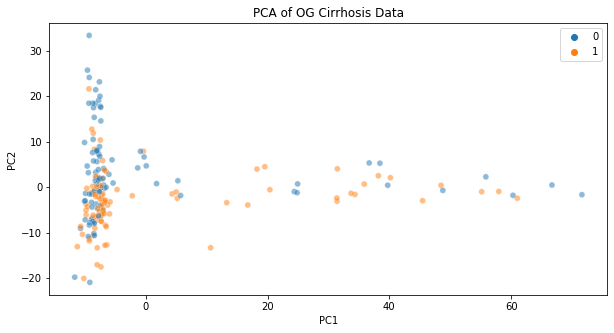

In [44]:
pc = PCA(n_components = 2)
plt.figure(figsize = (10,5))
x = pc.fit_transform( lightning.train_dataset.matrix.detach().numpy() )
sns.scatterplot(x = x[:, 0], y = x[:, 1], hue = lightning.train_dataset.y.detach().numpy(), alpha = 0.5)#.str.upper().str.strip())
plt.title('PCA of OG Cirrhosis Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim([-0.025, 0.001])
plt.show()

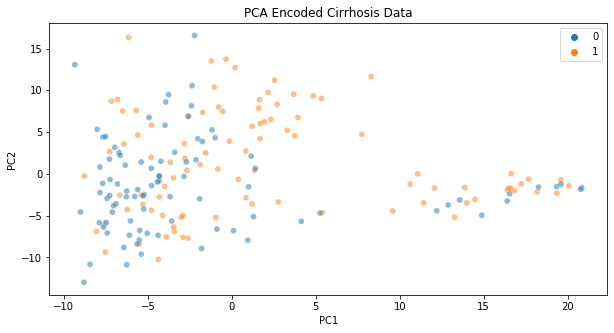

In [46]:
pc = PCA(n_components = 2)
plt.figure(figsize = (10,5))
x = pc.fit_transform( lightning.model.encode(lightning.train_dataset.matrix).detach().numpy() )
sns.scatterplot(x = x[:, 0], y = x[:, 1], hue = lightning.train_dataset.y.detach().numpy(), alpha = 0.5)#.str.upper().str.strip())
plt.title('PCA Encoded Cirrhosis Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim([-0.025, 0.001])
plt.show()

In [ ]:
# listing out the parameters that need to be tuned
layer_size = [32, 64, 128, 256, 512]
n_layers = [1,2]
classifier_model = ['svm', 'rf']

In [ ]:
# rf tuning
n_estimators = [100, 300, 500, 700, 900]
min_samples_leaf = [1, 2, 3, 4, 5]
criteria = ['Gini impurity', 'information gain']

#svm tuning
C = [np.power(2., a) for a in [-5, -3, -1, 1, 3, 5]]
rbf_coef = [np.power(2., a) for a in [-15, -13, -11, -9, -7, -5, -3, -1, 2, 23]]

In [ ]:
# need 2 layers of tuning... rather

In [135]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TestTubeLogger

In [260]:
class LitEncoderDecoder(pl.LightningModule):
    def __init__(self, 
                 train_df,
                 valid_df, 
                 layer_dim = 64,
                 dropout = .2,
                 learning_rate=1e-3, 
                 batch_size=50, 
                 is_marker=False):
        super().__init__()
        
        self.train_dataset = MicroDataset(train_df, is_marker=is_marker)
        self.valid_dataset = MicroDataset(valid_df, is_marker=is_marker)
        #self.test_dataset = MicroDataset(test_df)
        
        
        self.train_loader = DataLoader(self.train_dataset, batch_size = batch_size, shuffle = True)
        self.valid_loader = DataLoader(self.valid_dataset, batch_size = batch_size, shuffle = False)
        #test_dataloader = DataLoader(self.test_dataset, batch_size = 50, shuffle = False)
        self.model = SAE(self.train_dataset, layer_dim = layer_dim, dropout = dropout)
        self.learning_rate = learning_rate
        
        # they use MSE for reconstruction loss
        self.loss_func = nn.MSELoss()
        
        
    def train_dataloader(self):
        return(self.train_loader)
    
    def val_dataloader(self):
        return(self.valid_loader)
    
    def forward(self, x):
        x = self.model(x)
        return x

    def split_batch(self, batch):
        return batch[0], batch[1]

    def training_step(self, batch, batch_idx):
        x, y = self.split_batch(batch)
        y_hat = self(x)
        loss = self.loss_func(y_hat, x)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = self.split_batch(batch)
        y_hat = self(x)
        loss = self.loss_func(y_hat, x)
        self.log('val_loss', loss)
        return {'val_loss':loss}
        
#     def validation_epoch_end(self, outputs):
#         # OPTIONAL
#         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
#         print('on val end')
#         return {'val_loss': avg_loss}

#     def test_step(self, batch, batch_idx):
#         x, y = self.split_batch(batch)
#         y_hat = self(x)
#         loss = F.cross_entropy(y_hat, y)
#         self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)




In [179]:
lightning = LitEncoderDecoder(train_df, 
                              valid_df, 
                              layer_dim = 32, 
                              learning_rate = .001,
                              batch_size=50
                              )
checkpoint_callback=ModelCheckpoint(
                dirpath = 'checkpoint_dir',
                save_top_k=1,
                verbose=False,
                monitor='val_loss',
                mode='min'
                )

tube_logger = TestTubeLogger('checkpoint_dir', 
                            name='test_tube_logger')

trainer = pl.Trainer(max_epochs = 500,
                     logger=tube_logger,
                     progress_bar_refresh_rate=0,
                     weights_summary=None,
                     check_val_every_n_epoch=1,
                     checkpoint_callback=checkpoint_callback,
                    callbacks=[EarlyStopping(monitor='val_loss', 
                                            patience=20)])

trainer.fit(lightning)

lightning.load_state_dict(torch.load(checkpoint_callback.best_model_path )['state_dict'])
lightning=lightning.eval()
print('done!')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


done!


In [146]:
pl.__version__

'1.2.4'

In [ ]:
# rf tuning
n_estimators = [100, 300, 500, 700, 900]
min_samples_leaf = [1, 2, 3, 4, 5]
criteria = ['Gini impurity', 'information gain']

#svm tuning
C = [np.power(2., a) for a in [-5, -3, -1, 1, 3, 5]]
rbf_coef = [np.power(2., a) for a in [-15, -13, -11, -9, -7, -5, -3, -1, 2, 23]]

In [129]:
SAE_parameters = [
    {
     'name':'layer_size', 
     'type':'choice', 
     'values':[32, 64, 128, 256, 512]
    },
    {
    'name':'classifier_model',
    'type':'choice',
    'values':['svm', 'rf']
    }
    ]

rf_parameters = [
      {
     'name':'n_estimators', 
     'type':'choice', 
     'values':[100, 300, 500, 700, 900]
    },
         {
     'name':'min_samples_leaf', 
     'type':'choice', 
     'values':[1, 2, 3, 4, 5]
    },
         {
     'name':'criterion', 
     'type':'choice', 
     'values':['gini', 'entropy']
    }
]

svm_parameters = [
          {
     'name':'C',
     'type':'choice', 
     'values': [-5, -3, -1, 1, 3, 5]#[np.power(2., a).astype(float) for a in [-5, -3, -1, 1, 3, 5]]
    },
         {
     'name':'gamma', 
     'type':'choice', 
     'values':[-15, -13, -11, -9, -7, -5, -3, -1, 2, 23]#[np.power(2., a).astype(float) for a in [-15, -13, -11, -9, -7, -5, -3, -1, 2, 23]]
    }
]

In [115]:
[np.power(2., a).astype(float) for a in [-5, -3, -1, 1, 3, 5]]

[0.03125, 0.125, 0.5, 2.0, 8.0, 32.0]

In [114]:
[np.power(2., a).astype(float) for a in [-15, -13, -11, -9, -7, -5, -3, -1, 2, 23]]

[3.0517578125e-05,
 0.0001220703125,
 0.00048828125,
 0.001953125,
 0.0078125,
 0.03125,
 0.125,
 0.5,
 4.0,
 8388608.0]

In [95]:
rf_param = {'n_estimators':400,
           'min_samples_leaf':3, 
           'criterion':'gini'}

In [51]:
train_dataset = MicroDataset(train_df)
valid_dataset = MicroDataset(valid_df)

In [64]:
recombined_df = np.vstack([train_dataset.matrix.detach().numpy(), valid_dataset.matrix.detach().numpy()])

In [72]:
recombined_y = np.hstack([train_dataset.y.detach().numpy(),
                          valid_dataset.y.detach().numpy()] )

In [ ]:
RandomForestClassifier(rf_param)

In [ ]:
run_training()

In [74]:
model = RandomForestClassifier()

In [85]:
[ setattr(model, a, q) for a,q in rf_param.items() ]

[None, None, None]

In [86]:
model.criterion

'atba'

In [92]:
X = recombined_df
y=recombined_y
n_folds=5

In [96]:
def evaluation_func(p):
    model=RandomForestClassifier()
    [setattr(model, a, q) for a,q in p.items()]
    roc, model = run_training(X, y, n_folds=n_folds, model=model)
    return(auc(roc[0], roc[1]))


In [97]:
evaluation_func(rf_param)

0.9471454058876004

In [128]:
rf_parameters

[{'name': 'n_estimators',
  'type': 'choice',
  'values': [100, 300, 500, 700, 900]},
 {'name': 'min_samples_leaf', 'type': 'choice', 'values': [1, 2, 3, 4, 5]},
 {'name': 'criteria', 'type': 'choice', 'criterion': ['gini', 'entropy']}]

In [201]:
def rf_eval(X, y, rf_hyperparams, n_folds=5, total_trials=10):
    # find the best hyperamas vis k-fold cross-validation
    
    def evaluation_func(p):
        #the function used for the hyperparameter tuning
        model=RandomForestClassifier()
        [setattr(model, a, q) for a,q in p.items()]
        roc, model = run_training(X, y, n_folds=n_folds, model=model)
        return(auc(roc[0], roc[1]))
    
    best_parameters, best_values, experiment, model = optimize(
        parameters = rf_hyperparams,
        evaluation_function=evaluation_func,
        total_trials=total_trials, 
        minimize=False)
    
    return(best_parameters)
    
    
def svm_eval(X, y, svm_hyperparams, n_folds=5, total_trials=10):
    # find the best hyperamas vis k-fold cross-validation
    
    def evaluation_func(p):
        #the function used for the hyperparameter tuning
        model=SVC(probability=True)
        [setattr(model, a, np.power(2., q)) for a,q in p.items()]
        roc, model = run_training(X, y, n_folds=n_folds, model=model)
        return(auc(roc[0], roc[1]))
    
    best_parameters, best_values, experiment, model = optimize(
        parameters = svm_hyperparams,
        evaluation_function=evaluation_func, 
        total_trials = total_trials, 
        minimize=False)
    
    return(best_parameters)
    

In [200]:
best_params

{'n_estimators': 700, 'min_samples_leaf': 1, 'criterion': 'gini'}

In [198]:
best_params, best_rf_model = rf_eval(recombined_df, recombined_y, rf_parameters)

[INFO 03-27 13:37:27] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 13:37:27] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 13:37:27] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 13:37:31] ax.service.managed_loop: Running optimization trial 2...


[INFO 03-27 13:37:37] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 13:37:44] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 13:37:50] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 13:37:51] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 13:37:58] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 13:37:59] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 13:38:06] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 13:38:09] ax.service.managed_loop: Running optimization trial 10...


In [199]:
best_rf_model

In [126]:
best_params, best_svm_model = svm_eval(recombined_df, recombined_y, svm_parameters)

[INFO 03-27 12:36:28] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 12:36:28] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 12:36:28] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 12:36:28] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 12:36:29] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 12:36:29] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 12:36:30] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 12:36:31] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 12:36:32] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 12:36:32] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 12:36:33] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 12:36:34] ax.service.managed_loop: Running optimization trial 10...


In [132]:
best_svm_model

In [133]:
best_params

{'n_estimators': 900, 'min_samples_leaf': 2, 'criterion': 'entropy'}

In [102]:
from ax import optimize

In [ ]:
SAE_parameters = [
    {
     'name':'layer_size', 
     'type':'choice', 
     'values':[32, 64, 128, 256, 512]
    },
    {
    'name':'classifier_model',
    'type':'choice',
    'values':['svm', 'rf']
    }
    ]



In [192]:
sae_params={'layer_size':30, 
           'classifier_model':'rf'}

In [267]:
dataset = markers[0]
train_df, test_df = make_split(dataset)
train_df, valid_df = make_split(train_df)

def SAE_eval(hyperparams):
    """this function runs a complete train/valid/testing loop
        for an SAE model, given the specified hyperparameters, 
        it returns the AUC on the test set"""
    #Initialize the model
    lightning = LitEncoderDecoder(train_df, 
                                  valid_df, 
                                  layer_dim = hyperparams['layer_size'], 
                                  learning_rate = .001,
                                  batch_size=50, 
                                  is_marker=is_marker
                                  )
    
    #setr up the trainer/logger/callbacks
    checkpoint_callback=ModelCheckpoint(
                    dirpath = 'checkpoint_dir',
                    save_top_k=1,
                    verbose=False,
                    monitor='val_loss',
                    mode='min'
                    )

    tube_logger = TestTubeLogger('checkpoint_dir', 
                                name='test_tube_logger')

    trainer = pl.Trainer(max_epochs = 500,
                         logger=tube_logger,
                         progress_bar_refresh_rate=0,
                         weights_summary=None,
                         check_val_every_n_epoch=1,
                         checkpoint_callback=checkpoint_callback,
                        callbacks=[EarlyStopping(monitor='val_loss', 
                                                patience=20)]) #the patience of 20 is mentioned in the DeepMicro paper

    #run training
    trainer.fit(lightning)

    #load model from best-performing epoch
    lightning.load_state_dict(torch.load(checkpoint_callback.best_model_path )['state_dict'])
    #set model to eval()
    lightning=lightning.eval()
    
    #recombine the train/valid datasets for k-fold validation, as descrbed in the paper
    X = np.vstack([lightning.model.encode(lightning.train_dataset.matrix).detach().numpy(), 
                   lightning.model.encode(lightning.valid_dataset.matrix).detach().numpy()])
    
    y = np.hstack([lightning.train_dataset.y.detach().numpy(),
                   lightning.valid_dataset.y.detach().numpy()] )
    
    #set up classifier model tuning
    if hyperparams['classifier_model']=='rf':
        eval_model=rf_eval
        eval_params = rf_parameters
    elif hyperparams['classifier_model']=='svm':
        eval_model=svm_eval
        eval_params=svm_parameters
    
    #tune the best classifier model, using 5-fold CV
    best_parameters=eval_model(X,y, eval_params)
    
    # make a classifier with teh best hyperparams
    if hyperparams['classifier_model']=='rf':
        best_classifier=RandomForestClassifier()
        [setattr(model, a, q) for a,q in best_parameters.items()]
        
    elif hyperparams['classifier_model']=='svm':
        best_classifier=SVC(probability=True)
        [setattr(best_classifier, a, np.power(2., q)) for a,q in best_parameters.items()]
        
    # fit it on the full train, valid data
    best_classifier.fit(X, y)
    
    # Get AUC for the full setup on the test set
    test_dataset=MicroDataset(test_df, is_marker=is_marker)
    test_preds=best_classifier.predict_proba( lightning.model.encode(test_dataset.matrix).detach().numpy() )
    test_roc = roc_curve( test_dataset.y.detach().numpy(), test_preds[:,1] )
    return(auc(test_roc[0], test_roc[1]) )

In [216]:
SAE_parameters

[{'name': 'layer_size', 'type': 'choice', 'values': [32, 64, 128, 256, 512]},
 {'name': 'classifier_model', 'type': 'choice', 'values': ['svm', 'rf']}]

In [222]:
def tune_SAE(dataset, SAE_parameters, is_marker=False, seed=0,  total_trials=8):
    #set a seed so that splits are the same across different model tests
    np.random.seed(seed)
    #make data splits
    train_df, test_df = make_split(dataset)
    train_df, valid_df = make_split(train_df)
    
     
    best_parameters, best_values, experiment, model = optimize(
        parameters = SAE_parameters,
        evaluation_function=SAE_eval, 
        total_trials = total_trials, 
        minimize=False)
    
    data_name=dataset.index[0] 
    if is_marker==False:
        data_type='Abundance'
    else:
        data_type='Marker'
    
    return([data_type, data_name, best_parameters, best_values])


In [268]:
model_results = tune_SAE(dataset, SAE_parameters)

[INFO 03-27 15:14:50] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 15:14:50] ax.service.managed_loop: Started full optimization with 8 steps.
[INFO 03-27 15:14:50] ax.service.managed_loop: Running optimization trial 1...
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

Checkpoint directory checkpoint_dir exists and is not empty.

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarni

[INFO 03-27 15:19:16] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 15:19:16] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 15:19:16] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 15:19:17] ax.service.managed_loop: Running optimization trial 10...
[INFO 03-27 15:19:17] ax.service.ma

[INFO 03-27 15:24:50] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 15:24:50] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 15:24:50] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 15:24:53] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 15:24:55] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 15:25:02] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 15:25:07] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 15:25:09] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 15:25:10] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 15:25:12] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 15:25:13] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 15:25:13] ax.service.managed_loop: Running optimization trial 10...


In [271]:
model_results[0] = 'Marker'

In [272]:
model_results

['Marker',
 'Zeller_fecal_colorectal_cancer',
 {'layer_size': 512, 'classifier_model': 'svm'},
 ({'objective': 0.7259259259259259}, {'objective': {'objective': 0.0}})]

In [234]:
[b for a,b in model_results[2].items()]

[128, 'svm']

In [236]:
model_results

['Abundance',
 'Quin_gut_liver_cirrhosis',
 {'layer_size': 128, 'classifier_model': 'svm'},
 ({'objective': 0.8369565217391305}, {'objective': {'objective': 0.0}})]

In [ ]:
a

In [273]:
[a if type(a)==str 
     else [b for c,b in a.items()] if type(a) == dict 
     else a[0]['objective']
    for a in model_results  ]

['Marker', 'Zeller_fecal_colorectal_cancer', [512, 'svm'], 0.7259259259259259]

In [244]:
SAE_results

,0,1,2,3
0,Abundance,Quin_gut_liver_cirrhosis,"[128, svm]",0.836957


In [251]:
SAE_results = pd.DataFrame(['SAE'] + [a if type(a)==str 
                         else [b for c,b in a.items()] if type(a) == dict 
                         else a[0]['objective']
                        for a in model_results]).T

SAE_results.columns = ['Model Type', 'Data Type', 'Dataset', 'hyperparams', 'AUC']

In [254]:
pd.concat( [pd.read_csv('SAE_results.csv'),SAE_results], axis=0 )
            

,Model Type,Data Type,Dataset,hyperparams,AUC
0,SAE,Abundance,Quin_gut_liver_cirrhosis,"[128, 'svm']",0.836957
0,SAE,Abundance,Quin_gut_liver_cirrhosis,"[128, svm]",0.836957


In [252]:
SAE_results.to_csv('SAE_results.csv', index=False)

In [250]:
pd.read_csv('SAE_results.csv').

,Data Type,Dataset,hyperparams,AUC
0,Abundance,Quin_gut_liver_cirrhosis,"[128, 'svm']",0.836957


In [225]:
model_results[2]

{'layer_size': 128, 'classifier_model': 'svm'}

In [226]:
SAE_eval(model_results[2])

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

Checkpoint directory checkpoint_dir exists and is not empty.

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

The dataload

0.8188405797101449

In [213]:
dataset.iloc[:5, :2]

dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp,...,read_length,total_reads,matched_reads,uniquely_matching_reads,uniquely_matched_reads,gene_number,gene_number_for_11m_uniquely_matched_reads,hitchip_probe_number,bmi,gene_count_class
Quin_gut_liver_cirrhosis,HD-10,hd-10,stool,n,40,female,china,Illumina,25079328,nd,...,nd,nd,nd,nd,nd,nd,nd,nd,20.2,nd
Quin_gut_liver_cirrhosis.1,HD-11,hd-11,stool,n,38,female,china,Illumina,25079328,nd,...,nd,nd,nd,nd,nd,nd,nd,nd,19.95,nd
Quin_gut_liver_cirrhosis.2,HD-12,hd-12,stool,n,40,male,china,Illumina,25079328,nd,...,nd,nd,nd,nd,nd,nd,nd,nd,22.55,nd
Quin_gut_liver_cirrhosis.3,HD-13,hd-13,stool,n,56,female,china,Illumina,25079328,nd,...,nd,nd,nd,nd,nd,nd,nd,nd,21.48,nd
Quin_gut_liver_cirrhosis.4,HD-14,hd-14,stool,n,51,male,china,Illumina,25079328,nd,...,nd,nd,nd,nd,nd,nd,nd,nd,22.58,nd


In [255]:
markers = []
for file in os.listdir('data/marker/'):
    df = pd.read_csv('data/marker/' + file, sep = '\t') 
    df.index = df.dataset_name
    markers.append(df.T.drop('dataset_name') )

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,1

In [256]:
dfs = []
for file in os.listdir('data/abundance/'):
    df = pd.read_csv('data/abundance/' + file, sep = '\t') 
    df.index = df.dataset_name
    dfs.append(df.T.drop('dataset_name') )

In [257]:
markers[0].head()

dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp,...,gi|62425186|ref|NZ_AAGP01000009.1|:99890-100180,gi|62425382|ref|NZ_AAGP01000007.1|:c1202-885,gi|62425382|ref|NZ_AAGP01000007.1|:c33801-33373,gi|62425382|ref|NZ_AAGP01000007.1|:c34305-33829,gi|62425604|ref|NZ_AAGP01000005.1|:60113-60766,gi|62425604|ref|NZ_AAGP01000005.1|:97318-98013,gi|62425739|ref|NZ_AAGP01000004.1|:59838-60017,gi|62425898|ref|NZ_AAGP01000003.1|:c34741-34619,gi|62426048|ref|NZ_AAGP01000002.1|:c74491-73856,gi|89892746|ref|NC_007907.1|:41100-41594
Zeller_fecal_colorectal_cancer,CCIS00146684ST-4-0,fr-726,stool,n,72,female,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0
Zeller_fecal_colorectal_cancer.1,CCIS00281083ST-3-0,fr-060,stool,n,53,male,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0
Zeller_fecal_colorectal_cancer.2,CCIS02124300ST-4-0,fr-568,stool,n,35,male,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0
Zeller_fecal_colorectal_cancer.3,CCIS02379307ST-4-0,fr-828,stool,cancer,67,male,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0
Zeller_fecal_colorectal_cancer.4,CCIS03473770ST-4-0,fr-192,stool,n,29,male,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0


In [280]:
for i, dataset in enumerate(markers[3:]):
    is_marker=True
    model_results = tune_SAE(dataset, SAE_parameters)
    SAE_results = pd.DataFrame(['SAE'] + [a if type(a)==str 
                             else [b for c,b in a.items()] if type(a) == dict 
                             else a[0]['objective']
                            for a in model_results]).T

    SAE_results.columns = ['Model Type', 'Data Type', 'Dataset', 'hyperparams', 'AUC']
    pd.concat( [pd.read_csv('SAE_results.csv'),SAE_results], axis=0 ).to_csv('SAE_results.csv', index=False)
    print('Got through the ' + str(i) + 'th Datase!')

[INFO 03-27 16:29:36] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 16:29:36] ax.service.managed_loop: Started full optimization with 8 steps.
[INFO 03-27 16:29:36] ax.service.managed_loop: Running optimization trial 1...
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

Checkpoint directory checkpoint_dir exists and is not empty.

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarni

[INFO 03-27 16:38:27] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 16:38:27] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 16:38:27] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 16:38:27] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 16:38:27] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 16:38:28] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 16:38:28] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 16:38:28] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 16:38:28] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 16:38:28] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 16:38:28] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 16:38:28] ax.service.managed_loop: Running optimization trial 10...
[INFO 03-27 16:38:28] ax.service.ma

[INFO 03-27 16:46:08] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 16:46:08] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 16:46:08] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 16:46:09] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 16:46:14] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 16:46:19] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 16:46:26] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 16:46:26] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 16:46:30] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 16:46:33] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 16:46:38] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 16:46:40] ax.service.managed_loop: Running optimization trial 10...


Got through the0th Datase!


[INFO 03-27 16:46:47] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 16:46:47] ax.service.managed_loop: Started full optimization with 8 steps.
[INFO 03-27 16:46:47] ax.service.managed_loop: Running optimization trial 1...
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

Checkpoint directory checkpoint_dir exists and is not empty.

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarni

[INFO 03-27 16:52:16] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 16:52:16] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 16:52:16] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 16:52:21] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 16:52:21] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 16:52:22] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 16:52:29] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 16:52:32] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 16:52:35] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 16:52:38] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 16:52:43] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 16:52:47] ax.service.managed_loop: Running optimization trial 10...
[INFO 03-27 16:52:48] ax.service.ma

[INFO 03-27 17:00:50] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 17:00:50] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 17:00:50] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 17:00:52] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 17:00:55] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 17:00:58] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 17:01:04] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 17:01:11] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 17:01:15] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 17:01:16] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 17:01:21] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 17:01:28] ax.service.managed_loop: Running optimization trial 10...


Got through the1th Datase!


[INFO 03-27 17:01:34] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 17:01:34] ax.service.managed_loop: Started full optimization with 8 steps.
[INFO 03-27 17:01:34] ax.service.managed_loop: Running optimization trial 1...
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

Checkpoint directory checkpoint_dir exists and is not empty.

GPU available: False, used: False
TPU available: None, using: 0 TPU cores
/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarni

[INFO 03-27 17:10:40] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 17:10:40] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 17:10:40] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 17:10:40] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 17:10:40] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 17:10:40] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 17:10:40] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 17:10:40] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 17:10:41] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 17:10:41] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 17:10:41] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 17:10:41] ax.service.managed_loop: Running optimization trial 10...
[INFO 03-27 17:10:41] ax.service.ma

[INFO 03-27 17:15:55] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 03-27 17:15:55] ax.service.managed_loop: Started full optimization with 10 steps.
[INFO 03-27 17:15:55] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 4...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 5...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 6...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 7...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 8...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 9...
[INFO 03-27 17:15:56] ax.service.managed_loop: Running optimization trial 10...


Got through the2th Datase!


In [263]:
dataset.head()

dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp,...,gi|62425186|ref|NZ_AAGP01000009.1|:99890-100180,gi|62425382|ref|NZ_AAGP01000007.1|:c1202-885,gi|62425382|ref|NZ_AAGP01000007.1|:c33801-33373,gi|62425382|ref|NZ_AAGP01000007.1|:c34305-33829,gi|62425604|ref|NZ_AAGP01000005.1|:60113-60766,gi|62425604|ref|NZ_AAGP01000005.1|:97318-98013,gi|62425739|ref|NZ_AAGP01000004.1|:59838-60017,gi|62425898|ref|NZ_AAGP01000003.1|:c34741-34619,gi|62426048|ref|NZ_AAGP01000002.1|:c74491-73856,gi|89892746|ref|NC_007907.1|:41100-41594
Zeller_fecal_colorectal_cancer,CCIS00146684ST-4-0,fr-726,stool,n,72,female,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0
Zeller_fecal_colorectal_cancer.1,CCIS00281083ST-3-0,fr-060,stool,n,53,male,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0
Zeller_fecal_colorectal_cancer.2,CCIS02124300ST-4-0,fr-568,stool,n,35,male,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0
Zeller_fecal_colorectal_cancer.3,CCIS02379307ST-4-0,fr-828,stool,cancer,67,male,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0
Zeller_fecal_colorectal_cancer.4,CCIS03473770ST-4-0,fr-192,stool,n,29,male,france,Illumina,25432777,nd,...,0,0,0,0,0,0,0,0,0,0


In [265]:
len( dfs )

6

In [266]:
[q.index[0] for q in dfs]

['Quin_gut_liver_cirrhosis',
 'WT2D',
 'Zeller_fecal_colorectal_cancer',
 'Chatelier_gut_obesity',
 'metahit',
 't2dmeta_long']